## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

## Load and Prepare Data

In [2]:
# Load dataset
digits = load_digits()
X, y = digits.data, digits.target

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Classes: {np.unique(y)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")


Dataset shape: (1797, 64)
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]
Training set shape: (1437, 64)
Test set shape: (360, 64)


## Initialize Models

In [3]:
models = {
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

## Baseline Evaluation

In [4]:
baseline_results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    baseline_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print()
    

SVM:
  Accuracy: 0.9750
  Precision: 0.9759
  Recall: 0.9750
  F1-Score: 0.9749

K-Nearest Neighbors:
  Accuracy: 0.9639
  Precision: 0.9648
  Recall: 0.9639
  F1-Score: 0.9636

Decision Tree:
  Accuracy: 0.8167
  Precision: 0.8162
  Recall: 0.8167
  F1-Score: 0.8155

Gradient Boosting:
  Accuracy: 0.9528
  Precision: 0.9531
  Recall: 0.9528
  F1-Score: 0.9523

Naive Bayes:
  Accuracy: 0.7417
  Precision: 0.8116
  Recall: 0.7417
  F1-Score: 0.7419



## GridSearchCV Tuning

In [5]:
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.01],
        'kernel': ['rbf', 'linear']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'criterion': ['gini', 'entropy']
    },
    'Naive Bayes': {
        'var_smoothing': np.logspace(-12, -6, 7)
    }
}

grid_search_results = {}

for name in param_grids:
    print(f"Tuning {name}...")
    model = models[name]
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    grid_search_results[name] = {
        'Best Params': grid_search.best_params_,
        'CV Score': grid_search.best_score_,
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1': f1,
        'Model': best_model
    }
    
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Test Accuracy: {accuracy:.4f}\n")

Tuning SVM...
Best CV Score: 0.9833
Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy: 0.9750

Tuning K-Nearest Neighbors...
Best CV Score: 0.9784
Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Test Accuracy: 0.9833

Tuning Decision Tree...
Best CV Score: 0.8657
Best Params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.8389

Tuning Naive Bayes...
Best CV Score: 0.8302
Best Params: {'var_smoothing': 1e-06}
Test Accuracy: 0.8056



## RandomizedSearchCV Tuning

In [6]:
param_dists = {
    'SVM': {
        'C': np.logspace(-2, 2, 10),
        'gamma': np.logspace(-3, 1, 10),
        'kernel': ['rbf', 'linear']
    },
    'Gradient Boosting': {
        'n_estimators': np.arange(50, 300, 25),
        'learning_rate': np.linspace(0.01, 0.3, 10),
        'max_depth': np.arange(3, 15, 2),
        'subsample': np.linspace(0.6, 1.0, 5)
    }
}

random_search_results = {}

for name in param_dists:
    print(f"Tuning {name} with RandomizedSearchCV...")
    model = models[name]
    rand_search = RandomizedSearchCV(
        model, param_distributions=param_dists[name],
        n_iter=50, cv=5, scoring='accuracy',
        random_state=42, n_jobs=-1
    )
    rand_search.fit(X_train_scaled, y_train)
    
    best_model = rand_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    random_search_results[name] = {
        'Best Params': rand_search.best_params_,
        'CV Score': rand_search.best_score_,
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1': f1,
        'Model': best_model
    }
    
    print(f"Best CV Score: {rand_search.best_score_:.4f}")
    print(f"Best Params: {rand_search.best_params_}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print()


Tuning SVM with RandomizedSearchCV...
Best CV Score: 0.9840
Best Params: {'kernel': 'rbf', 'gamma': 0.007742636826811269, 'C': 35.93813663804626}
Test Accuracy: 0.9833

Tuning Gradient Boosting with RandomizedSearchCV...
Best CV Score: 0.9715
Best Params: {'subsample': 0.6, 'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.2677777777777778}
Test Accuracy: 0.9694



## Compare Baseline vs Tuned Models

In [7]:
print("Model Comparison Summary\n" + "="*30)
comparison = []

all_tuned = {**grid_search_results, **random_search_results}

for model_name in baseline_results:
    base = baseline_results[model_name]
    tuned = all_tuned.get(model_name)

    if tuned:
        improvement = tuned['Test Accuracy'] - base['Accuracy']
        comparison.append({
            'Model': model_name,
            'Baseline Acc': base['Accuracy'],
            'Tuned Acc': tuned['Test Accuracy'],
            'Improvement': improvement,
            'Tuned F1': tuned['Test F1']
        })

        print(f"{model_name}")
        print(f"  Baseline Accuracy: {base['Accuracy']:.4f}")
        print(f"  Tuned Accuracy: {tuned['Test Accuracy']:.4f}")
        print(f"  F1 Score: {tuned['Test F1']:.4f}")
        print(f"  Improvement: {improvement:.4f}")
        print()

comparison_df = pd.DataFrame(comparison)


Model Comparison Summary
SVM
  Baseline Accuracy: 0.9750
  Tuned Accuracy: 0.9833
  F1 Score: 0.9833
  Improvement: 0.0083

K-Nearest Neighbors
  Baseline Accuracy: 0.9639
  Tuned Accuracy: 0.9833
  F1 Score: 0.9833
  Improvement: 0.0194

Decision Tree
  Baseline Accuracy: 0.8167
  Tuned Accuracy: 0.8389
  F1 Score: 0.8392
  Improvement: 0.0222

Gradient Boosting
  Baseline Accuracy: 0.9528
  Tuned Accuracy: 0.9694
  F1 Score: 0.9693
  Improvement: 0.0167

Naive Bayes
  Baseline Accuracy: 0.7417
  Tuned Accuracy: 0.8056
  F1 Score: 0.8093
  Improvement: 0.0639



## Identify Best Model

In [8]:
best_model_info = None
best_acc = 0

for name, result in all_tuned.items():
    if result['Test Accuracy'] > best_acc:
        best_acc = result['Test Accuracy']
        best_model_info = {
            'Name': name,
            'Accuracy': result['Test Accuracy'],
            'Precision': result['Test Precision'],
            'Recall': result['Test Recall'],
            'F1': result['Test F1'],
            'Params': result['Best Params'],
            'Model': result['Model']
        }

print("Best Performing Model\n" + "="*25)
print(f"Model: {best_model_info['Name']}")
print(f"Accuracy: {best_model_info['Accuracy']:.4f}")
print(f"Precision: {best_model_info['Precision']:.4f}")
print(f"Recall: {best_model_info['Recall']:.4f}")
print(f"F1 Score: {best_model_info['F1']:.4f}")
print(f"Best Parameters: {best_model_info['Params']}")


Best Performing Model
Model: SVM
Accuracy: 0.9833
Precision: 0.9839
Recall: 0.9833
F1 Score: 0.9833
Best Parameters: {'kernel': 'rbf', 'gamma': 0.007742636826811269, 'C': 35.93813663804626}


## Detailed Evaluation of Best Model

In [11]:
print("Detailed Evaluation of Best Model\n" + "="*40)

y_pred = best_model_info['Model'].predict(X_test_scaled)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Cross-validation
cv_scores = cross_val_score(best_model_info['Model'], X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Detailed Evaluation of Best Model
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.97      0.97        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.95      0.97      0.96        36
           5       1.00      1.00      1.00        37
           6       0.97      1.00      0.99        36
           7       0.95      1.00      0.97        36
           8       1.00      0.94      0.97        35
           9       1.00      0.94      0.97        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

Cross-validation scores: [0.98958333 0.97222222 0.98954704 0.99303136 0.97560976]
Mean CV Score: 0.9840 (+/- 0.0168)


## Visualizing Comparison Results

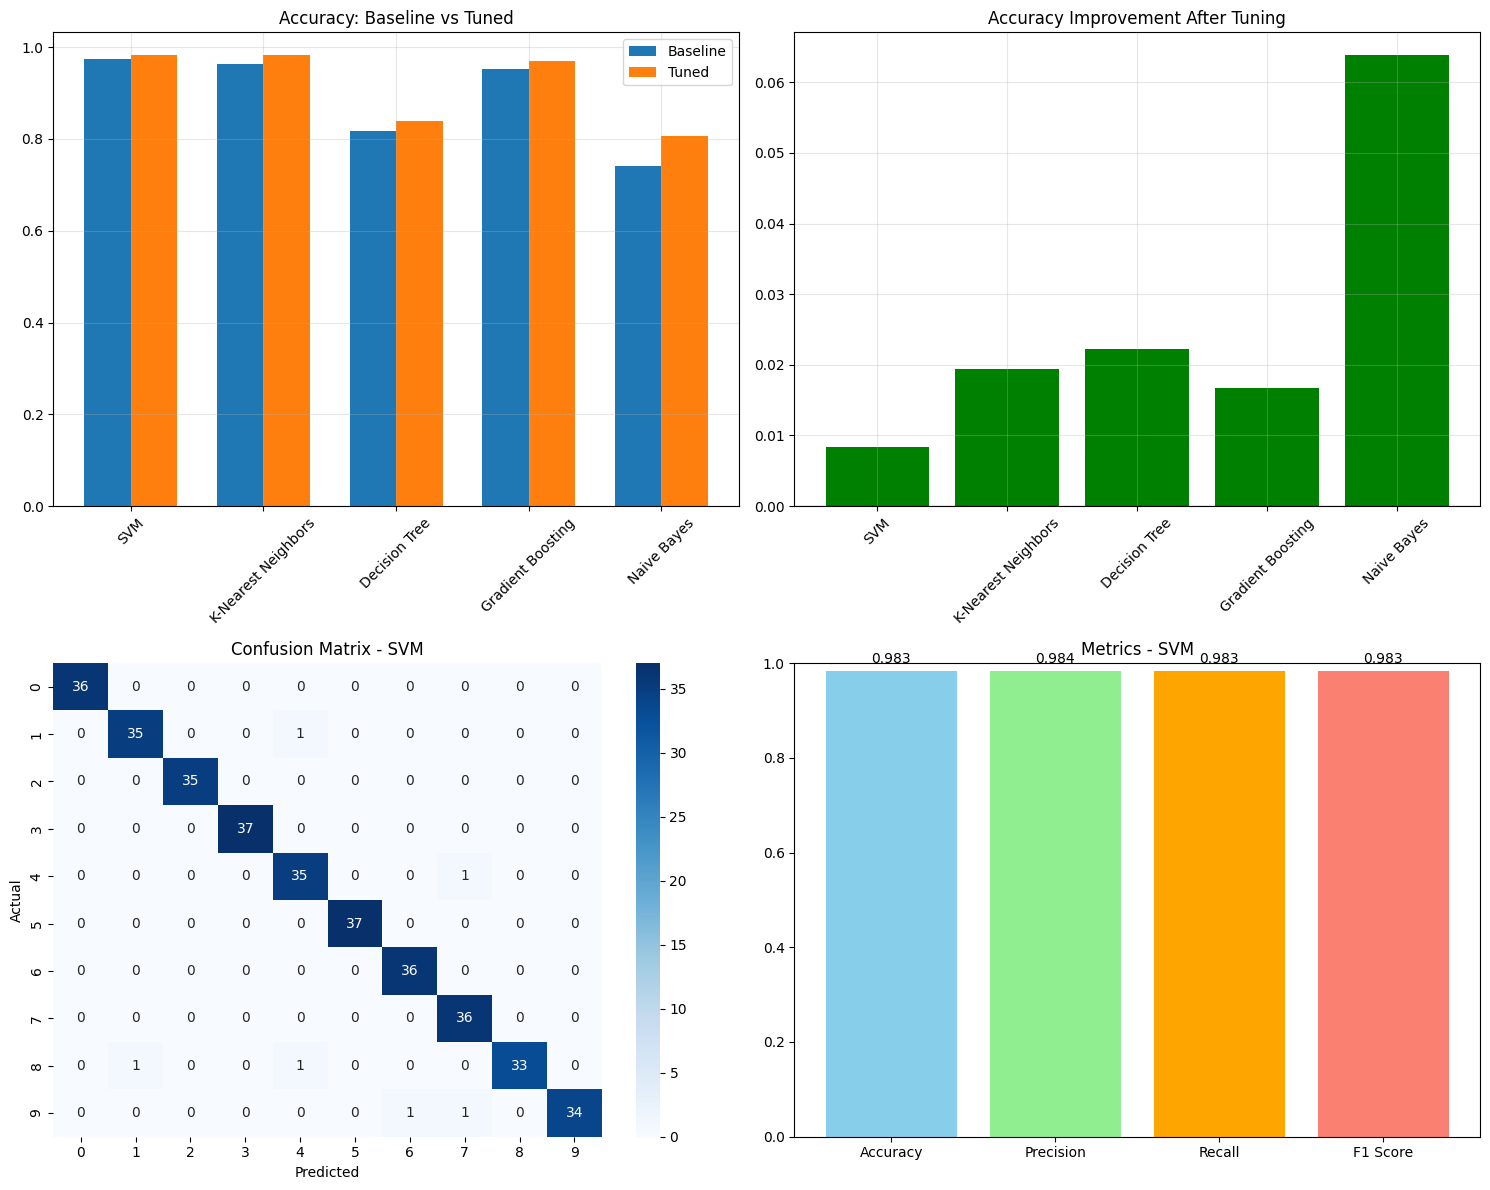

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Baseline vs Tuned Accuracy
ax1 = axes[0, 0]
models_list = comparison_df['Model']
baseline = comparison_df['Baseline Acc']
tuned = comparison_df['Tuned Acc']
x = np.arange(len(models_list))
width = 0.35

ax1.bar(x - width/2, baseline, width, label='Baseline')
ax1.bar(x + width/2, tuned, width, label='Tuned')
ax1.set_xticks(x)
ax1.set_xticklabels(models_list, rotation=45)
ax1.set_title("Accuracy: Baseline vs Tuned")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Accuracy Improvement
ax2 = axes[0, 1]
improvement = comparison_df['Improvement']
colors = ['green' if val > 0 else 'red' for val in improvement]
bars = ax2.bar(models_list, improvement, color=colors)
ax2.set_title("Accuracy Improvement After Tuning")
ax2.axhline(0, color='black', linewidth=0.8)
ax2.grid(True, alpha=0.3)
ax2.set_xticklabels(models_list, rotation=45)

# 3. Confusion Matrix (Again, for visualization consistency)
cm = confusion_matrix(y_test, y_pred)
ax3 = axes[1, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title(f'Confusion Matrix - {best_model_info["Name"]}')
ax3.set_xlabel("Predicted")
ax3.set_ylabel("Actual")

# 4. Performance Metrics Bar
ax4 = axes[1, 1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [best_model_info['Accuracy'], best_model_info['Precision'],
          best_model_info['Recall'], best_model_info['F1']]
bar_colors = ['skyblue', 'lightgreen', 'orange', 'salmon']
bars = ax4.bar(metrics, scores, color=bar_colors)
ax4.set_ylim(0, 1)
ax4.set_title(f'Metrics - {best_model_info["Name"]}')

# Add labels
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{score:.3f}",
             ha='center', va='bottom')

plt.tight_layout()
plt.show()
